In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [73]:
os.chdir(r"C:\Users\sd4be\Downloads\example")

In [74]:
path=r"C:\Users\sd4be\Downloads\example"
file='example.csv'

data=pd.read_csv("example.csv")

In [75]:
#data['공급 일자 및 시각']=data['공급일자']+' '+data['구매시각']
#data.drop(columns=['공급일자','구매시각','연령대'],inplace=True)
#data.to_csv(os.path.join(path,file))

In [76]:
data.columns

columns={
    '공급 일자 및 시각':'stamp',
    '요일':'day',
    '공급월':'month',
    '공급주차':'week',
    '회원번호':'id',
    '조합원상태':'member',
    '물품대분류':'category_L',
    '물품중분류':'category_M',
    '물품소분류':'category_S',
    '물품명':'name',
    '구매수량':'quant',
    '주소-구':'district',
    '주소-동':'neighborhood',
    '성별':'gender',
    '연령':'age',
    '구매금액':'amount',
    '구매매장':'branch',
    '반품_원거래일자':'refund_date'
}


data.rename(columns=columns,inplace=True)
data.drop('Unnamed: 0',axis=1,inplace=True)


### 1. Preprocessing (전처리)

### 1. Handling Column(age) 

### 1.1 Filling Missing Values

In [77]:
# create age groups 
data.age.describe().astype(int)

random_index=np.random.randint(0,len(data),500)
data.loc[random_index,'age']=np.nan

print("# of null values",data.age.isnull().sum())
print("% of null values",data.age.isnull().sum()/data.shape[0])

#plt.boxplot(data.age)

# of null values 533
% of null values 0.000755416534976636


In [78]:
missing_ids=data[data.age.isna()]['id'].unique().tolist()
condition=(data.id.isin(missing_ids))&(data.age.notnull())
ages=data.loc[condition,['id','age']].drop_duplicates()
data=data.merge(ages,on='id',how='left')

In [79]:
data.age_x.fillna(data.age_y,inplace=True)
data=data.drop(columns='age_y')
data=data.rename(columns={'age_x':'age'})
data=data[data.age.notnull()]

### 1.2 Create Age Groups

In [80]:
def create_group(x):
    if x<20:
        return "10's"
    elif x<30:
        return "20's"
    elif x<40:
        return "30's"
    elif x<50:
        return "40's"
    elif x<60:
        return "50's"
    elif x<70:
        return "60's"
    else:
        return "over 70's"

data['age_group']=data.age.map(lambda x:create_group(x))    

### 2. Analysis

### 2.1  Purchase Amount by Groups

In [81]:
columns=['id','age_group']
by=['amount','quant']
age_groups=data.groupby(columns)[by].sum().reset_index()

In [82]:
statics=pd.pivot_table(age_groups,index='age_group',values=['amount','quant'],aggfunc=['sum','mean']).round(2)
statics.columns.rename(['agg_function','items'],inplace=True)
statics.stack('agg_function')

items                         amount      quant
age_group agg_function                         
10's      mean          4.661505e+05      61.75
          sum           9.323010e+05     123.50
20's      mean          6.677867e+05      72.49
          sum           2.938262e+07    3189.70
30's      mean          5.066273e+05      57.69
          sum           1.017814e+09  115908.36
40's      mean          6.570078e+05      69.59
          sum           2.876380e+09  304643.92
50's      mean          8.174634e+05      80.80
          sum           2.020769e+09  199739.16
60's      mean          7.521932e+05      77.12
          sum           1.077893e+09  110515.42
over 70's mean          7.903148e+05      79.96
          sum           6.812513e+08   68926.75

The pivot table displays the amount of purchaases of each group in our sample. However, the numer iteself is a little confusing for the comparing purpose. We better find a better approach to transform the display so that it becomre more readable to the users of this data source. 

In [83]:
purchase_values=pd.concat([statics[('sum', 'amount')]/statics[('sum','amount')].sum()*100,statics[('sum','amount')]],axis=1)
purchase_values=purchase_values.round(2)
purchase_values.columns=['percent','value']
purchase_values.percent=purchase_values.percent.astype(str)
purchase_values.percent=purchase_values.percent+' %'

In [84]:
purchase_values

,percent,value
age_group,,
10's,0.01 %,932301
20's,0.38 %,29382616
30's,13.21 %,1017814272
40's,37.33 %,2876380009
50's,26.23 %,2020769486
60's,13.99 %,1077892822
over 70's,8.84 %,681251328


### 2.2  split group

In [85]:
active=data[data.member=='정상회원']
inactive=data[data.member!='정상회원']

### 2.3 Total Purchase

([<matplotlib.patches.Wedge at 0x2bcf1de1880>,
 [Text(-1.0989440748913437, 0.04818630781880795, 'Active'),
  Text(1.5984641044213326, -0.07008927789974521, 'Inactive')],
 [Text(-0.5994240408498238, 0.026283440628440697, '98.6%'),
  Text(1.0989440717896661, -0.04818637855607483, '1.4%')])

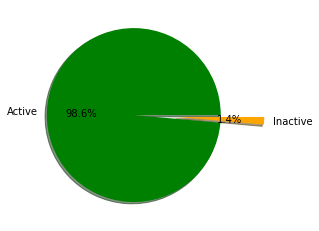

In [94]:
ratio=[len(active)/data.shape[0],len(inactive)/data.shape[0]]
labels=['Active','Inactive']
colors=['green','orange']
explode=[0,0.5]
plt.pie(ratio,labels=labels,explode=explode,colors=colors,autopct='%.1f%%',shadow=True)

Those who withdraw from the membership only count for 1.4 % of the total proportion. The number itself can be relatively small in the retail sector. However, it is worthwhile to compute the distribution of age groups according to the membership status so that we find groups from which the majority of withdrawal comes.

In [87]:
columns=['id','age_group']

stat_act=active.groupby(columns)['amount'].sum()
stat_act=stat_act.reset_index()
stat_act=stat_act.groupby("age_group")['amount'].sum()
percent_act=stat_act/stat_act.sum()*100
percent_act=percent_act.round(2).astype(str)+' %'


stat_inact=inactive.groupby(columns)['amount'].sum()
stat_inact=stat_inact.reset_index()
stat_inact=stat_inact.groupby("age_group")['amount'].sum()
percent=stat_inact/stat_inact.sum()*100
percent=percent.round(2).astype(str)+' %'

results=pd.concat([percent_act,percent],axis=1)
results.columns=['active','inactive']

Still, consumers aged between 40 and '50s are the big spenders. The groups account for almost 80 % of the total proportion. However, the higher number of withdrawal membership comes from the '30s and '40s having a strong purchasing power. We need to take a further analysis on these groups to see if the number occurs by chance. 


### 2.4 gender

In [88]:
for c in data.select_dtypes('object').columns:
    max_length=len(max(data.loc[:,c].dropna()))
    print("{}- max_length: {}".format(c,max_length))
    

day- max_length: 1
member- max_length: 5
category_L- max_length: 3
category_M- max_length: 3
category_S- max_length: 2
name- max_length: 9
district- max_length: 2
neighborhood- max_length: 4
gender- max_length: 1
branch- max_length: 3
stamp- max_length: 16
age_group- max_length: 9


##  3. Transfer data to MySQL datdabase

First,create a table named Retails by wrting a simple query. 



```sql
CREATE TABLE IF NOT EXISTS Retail (
   id int unsigned not null,
   member varchar(6),
   category_L varchar(50),
   category_M varchar(50),
   category_S varchar(50),
   quant smallint,
   amount numeric,
   name varchar(50),
   district varchar(50)
   neighborhood varchar(50),
   gender varchar(50),
   branch varchar(50),
   stamp varchar(50),
   age_group varchar(50)
);
```

Next,we need to transfer all the data to the newly created table using pymysql.The code will be displayed as below. 

In [89]:
import pymysql
config={
    'host':'127.0.0.1',
    'port':3306,
    'username':'root',
    'database':'sector_01',
    'password':'root1!'
}

def check_db_info(db_info):
    try:
        conn=pymysql.connect(
            host=db_info['host'],
            port=int(db_info['port']),
            user=db_info['username'],
            database=db_info['database'],
            passwd=db_info['password'],
            use_unicode=True,
            charset='utf8')
        cursor=conn.cursor()
        return conn,cursor
    except:
        raise ValueError
        

def insert_row(cursor,data,table):
    assert type(data)==dict

    placeholder=','.join(['%s']*len(data))
    fields=','.join(data.keys())
    key_placeholder=','.join(['{}=%s'.format(col) for col in data.keys()])
    sql='INSERT INTO %s (%s) VALUES (%s) ON DUPLICATE KEY UPDATE %s' %(table,fields,placeholder,key_placeholder)

    cursor.execute(sql,list(data.values())*2)

        
conn,cursor=check_db_info(config)

In [91]:
ids=['id','member',
     'category_L',
     'category_M',
     'category_S',
     'quant',
     'name',
     'district',
     'neighborhood',
     'gender',
     'branch',
     'stamp',
     'age_group',
     'amount',
     'quant']



active = active.where((pd.notnull(active)), None)
active=active.loc[:,ids]
active_dict=active.to_dict('records')




C:\Users\sd4be\AppData\Local\Temp/ipykernel_5704/1415695632.py:20: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  active_dict=active.to_dict('records')


In [92]:
conn,cursor=check_db_info(config)
for d in active_dict[4000:]:
    insert_row(cursor=cursor,data=d,table='Retail')
conn.commit()
conn.close()

### 3.1 RFM Analysis

The following code will let us prepare a dataframe with three features

```sql
WITH purchase_log AS (
  SELECT id AS user_id, 
		 substring(stamp,1,10) AS dt,
         sum(amount) AS amount
         FROM Retail
         GROUP BY user_id,dt)
  ,statistics AS(
  SELECT  user_id,
		  datediff(cast(max(max(dt)) over() as date),cast(max(dt) as date)) AS recency,
		  count(dt) AS frequency,
          sum(amount) AS monetary
          FROM purchase_log
          GROUP BY user_id)
,rfm_ranks as(
  SELECT user_id,
         recency,
         frequency,
         monetary,
         CASE WHEN recency <=36 THEN 1 
              WHEN recency <=72 THEN 2
              WHEN recency <=108 THEN 3
              WHEN recency <=144 THEN 4
              ELSE 5 END AS r,
		CASE WHEN frequency<=30 THEN 1
             WHEN frequency<=60 THEN 2
             WHEN frequency<=90 THEN 3
             when frequency<=120 then 4
             ELSE 5 END AS f,
	    CASE WHEN monetary<=30000000/5 THEN 1
             WHEN monetary<=30000000/4 THEN 2
             WHEN monetary<=30000000/3 THEN 3
             WHEN monetary<=30000000/2 THEN 4
             ELSE 5 END AS m
		FROM statistics)
	,mst_rfm_index as(
	SELECT 1 AS rfm_index
    UNION ALL SELECT 2 AS rfm_index
    UNION ALL SELECT 3 AS rfm_index
    UNION ALL SELECT 4 AS rfm_index
    UNION ALL SELECT 5 AS rfm_index
    )
    ,rfm_flag AS(
    SELECT m.rfm_index,
           CASE WHEN m.rfm_index=r.r THEN 1 END AS r_flag,
		   CASE WHEN m.rfm_index=r.f THEN 1 END AS f_flag,
           CASE WHEN m.rfm_index=r.m THEN 1 END AS m_flag
     from mst_rfm_index as m
     cross join rfm_ranks as r)
   SELECT  rfm_index,
           SUM(r_flag) AS r,
		   SUM(f_flag) AS f,
           SUM(m_flag) AS m
           FROM rfm_flag
           GROUP BY rfm_index;
```

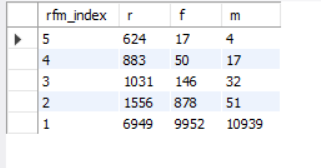

It seems to be hassle finding the pattern of consumers with dataframe with three-dimensional. Let's make a little modification on our table so that we can esialy get an inisight from the result in hand. Here, we will try out preparing dataframew with smaller dimensions just like dimension reduction. 


### 3.1.2 Dataframe with the only one diemnsion

```sql
WITH purchase_log AS (
  SELECT id AS user_id, 
		 substring(stamp,1,10) AS dt,
         sum(amount) AS amount
         FROM Retail
         GROUP BY user_id,dt)
  ,statistics AS(
  SELECT  user_id,
		  datediff(cast(max(max(dt)) over() as date),cast(max(dt) as date)) AS recency,
		  count(dt) AS frequency,
          sum(amount) AS monetary
          FROM purchase_log
          GROUP BY user_id)
,rfm_ranks as(
  SELECT user_id,
         recency,
         frequency,
         monetary,
         CASE WHEN recency <=36 THEN 1 
              WHEN recency <=72 THEN 2
              WHEN recency <=108 THEN 3
              WHEN recency <=144 THEN 4
              ELSE 5 END AS r,
		CASE WHEN frequency<=30 THEN 1
             WHEN frequency<=60 THEN 2
             WHEN frequency<=90 THEN 3
             when frequency<=120 then 4
             ELSE 5 END AS f,
	    CASE WHEN monetary<=30000000/5 THEN 1
             WHEN monetary<=30000000/4 THEN 2
             WHEN monetary<=30000000/3 THEN 3
             WHEN monetary<=30000000/2 THEN 4
             ELSE 5 END AS m
		FROM statistics)
	SELECT r+f+m AS total_ranks,
		   COUNT(user_id) AS counts
           FROM rfm_ranks
           GROUP BY total_ranks
           ORDER BY total_ranks DESC;
```

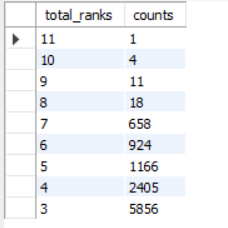

### 3.1.2 Dataframe with Two dimensions

```sql
WITH purchase_log AS (
  SELECT id AS user_id, 
		 substring(stamp,1,10) AS dt,
         sum(amount) AS amount
         FROM Retail
         GROUP BY user_id,dt)
  ,statistics AS(
  SELECT  user_id,
		  datediff(cast(max(max(dt)) over() as date),cast(max(dt) as date)) AS recency,
		  count(dt) AS frequency,
          sum(amount) AS monetary
          FROM purchase_log
          GROUP BY user_id)
,rfm_ranks as(
  SELECT user_id,
         recency,
         frequency,
         monetary,
         CASE WHEN recency <=36 THEN 1 
              WHEN recency <=72 THEN 2
              WHEN recency <=108 THEN 3
              WHEN recency <=144 THEN 4
              ELSE 5 END AS r,
		CASE WHEN frequency<=30 THEN 1
             WHEN frequency<=60 THEN 2
             WHEN frequency<=90 THEN 3
             when frequency<=120 then 4
             ELSE 5 END AS f,
	    CASE WHEN monetary<=30000000/5 THEN 1
             WHEN monetary<=30000000/4 THEN 2
             WHEN monetary<=30000000/3 THEN 3
             WHEN monetary<=30000000/2 THEN 4
             ELSE 5 END AS m
		FROM statistics)
   SELECT CONCAT('r',r) AS r_rank,
		COUNT(CASE WHEN f=5 THEN 1 END) AS f_5,
		COUNT(CASE WHEN f=4 THEN 1 END) AS f_4,
		COUNT(CASE WHEN f=3 THEN 1 END) AS f_3,
		COUNT(CASE WHEN f=2 THEN 1 END) AS f_2,
		COUNT(CASE WHEN f=1 THEN 1 END) AS f_1
        FROM rfm_ranks
        GROUP BY r
        ORDER BY r_rank DESC;
```

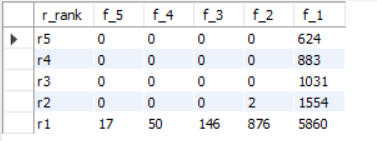
